In [1]:
import pandas as pd
import numpy as np

In [2]:
def train_test_split(X, y, test_p=0.25, random_state=42):
    ids = np.unique(X.index.values)
    test_size = math.floor(test_p * len(ids))
    test_index = np.random.choice(ids, size=test_size)
    X_train = X[~X.index.isin(test_index)]
    X_test = X[X.index.isin(test_index)]
    y_train = y[~y.index.isin(test_index)]
    y_test = y[y.index.isin(test_index)]
    return X_train, X_test, y_train, y_test

In [175]:
def feature_selection(X_train, y_train, model, variance_threshold=0, step=0.05, num_features=100, verbose=0, n_jobs=10):
    n = len(y_train)
    vals, counts = np.unique(y_train, return_counts=True)
    k = min(counts)
    # k = 5
    # Apply variance threshold on features
    # TODO: note that this is probably removing dummy variables with low variance; only matters in multi-drug case
    variance_selector = VarianceThreshold(threshold=variance_threshold)
    variance_selector.fit(X_train)
    var_selected_features = X_train.columns[variance_selector.get_support()]
    X_train_selected = X_train.loc[:, var_selected_features]

    # Recursive feature elimination with cross validation
    selector = RFECV(model, min_features_to_select=num_features, step=step, verbose=verbose, n_jobs=n_jobs, cv=k)
    # TODO: figure out way to output scores of intermediate selectors
    selector.fit(X_train_selected, y_train)
    selected_features = X_train_selected.columns[selector.get_support()]
    return selector, selected_features, var_selected_features

In [4]:
def test_model(X_test, y_test, model):
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return y_pred, score

## Imports and data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
discretize = 1

In [6]:
# expression_df = pd.read_csv('../data/processed/expression_tpm_log.tsv', sep='\t', index_col=0)
expression_df = pd.read_csv('../data/processed/expression_tpm_minmax.tsv', sep='\t', index_col=0)

In [7]:
expression_df = expression_df.set_index('pog_id')

In [8]:
drugs_df = pd.read_csv('../data/processed/drugs_prognosis.tsv', sep='\t', index_col=0)

## import Jasleen's labels

In [132]:
cin_data = pd.read_csv('../data/processed/coadread_stats.csv', encoding = "ISO-8859-1", index_col=0)
cin_data = cin_data.set_index('pog_id')

## set up master dfs

In [140]:
data_df = expression_df.join(cin_data, on='pog_id', how='inner')

In [145]:
data_df = data_df.drop_duplicates()

In [148]:
X_master = data_df.loc[:, expression_df.columns.values]
# X_master = pd.get_dummies(X_master, columns=['drug_name'])
y_master = data_df.loc[:, 'pattern']

## first try predicting between signature vs no signature

In [152]:
y = y_master

In [162]:
y = y.apply(lambda x: True if x != 'no SCP CIN' else False)

In [164]:
X = X_master

In [166]:
len(X)

87

In [167]:
len(y)

87

## sci-kit

In [168]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [169]:
from sklearn.preprocessing import PowerTransformer

In [170]:
from sklearn.feature_selection import RFECV, VarianceThreshold

In [171]:
from sklearn.model_selection import KFold, train_test_split

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Random forest with KFold

In [64]:
kf = KFold(n_splits=len(X), random_state=None, shuffle=False)

In [240]:
# RANDOM FOREST
selector, selected_columns, var_selected_features = feature_selection(X_train, y_train, RandomForestClassifier(n_jobs=64, n_estimators=1000, random_state=42), step=0.02, n_jobs=64, num_features=10, variance_threshold=0.01)

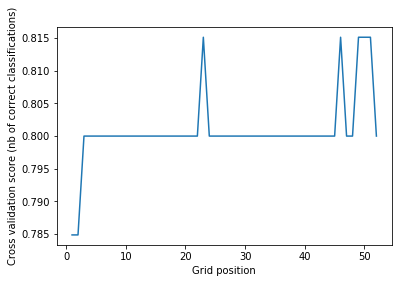

In [241]:
plt.figure()
plt.xlabel("Grid position")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [242]:
X_train.loc[:, selector.get_support()]

,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002079,ENSG00000002330,ENSG00000002549,ENSG00000002586,...,ENSG00000121644,ENSG00000121653,ENSG00000121671,ENSG00000121680,ENSG00000121690,ENSG00000121691,ENSG00000121716,ENSG00000121741,ENSG00000121742,ENSG00000121743
pog_id,,,,,,,,,,,,,,,,,,,,,
POG491,0.024546,0.087010,0.062079,0.042211,0.034772,0.120971,0.003543,0.124797,0.067993,0.084427,...,0.199377,0.012670,0.044130,0.287911,0.023109,0.104209,0.050043,0.134673,0.001033,0.002219
POG396,0.028086,0.028502,0.241703,0.173874,0.110515,0.097121,0.003543,0.253517,0.291886,0.036312,...,0.171464,0.014129,0.112218,0.449965,0.022260,0.192707,0.053947,0.213945,0.002622,0.158625
POG016,0.020947,0.157865,0.075656,0.050840,0.056311,0.124409,0.000394,0.146856,0.058950,0.012163,...,0.099065,0.007761,0.089659,0.233617,0.009066,0.170654,0.084184,0.200162,0.000174,0.008319
POG905,0.103362,0.112771,0.103620,0.062710,0.057503,0.250967,0.013386,0.216624,0.076278,0.094083,...,0.084237,0.021891,0.104808,0.506861,0.041819,0.222494,0.293828,0.100531,0.000070,0.001109
POG203,0.002487,0.233499,0.189023,0.088776,0.065212,0.128921,0.012992,0.174227,0.126828,0.021771,...,0.328224,0.014129,0.058455,0.265673,0.013194,0.135750,0.046140,0.206918,0.000012,0.014420
POG490,0.029110,0.063311,0.042237,0.061517,0.029844,0.131500,0.000394,0.175184,0.077316,0.106163,...,0.199875,0.022819,0.067347,0.258103,0.017322,0.136615,0.105014,0.175390,0.002692,0.009429
POG439,0.045142,0.052056,0.125551,0.212864,0.035845,0.039966,0.016535,0.318930,0.085667,0.112278,...,0.209844,0.017778,0.049564,0.465933,0.023842,0.144014,0.019390,0.148365,0.000000,0.002219
POG460,0.061174,0.084730,0.076236,0.030281,0.031632,0.096261,0.002362,0.195665,0.129579,0.078252,...,0.080249,0.026667,0.092211,0.424060,0.026735,0.173297,0.049211,0.173498,0.000220,0.021076
POG518,0.008748,0.128441,0.035159,0.038553,0.014823,0.042544,0.002362,0.165040,0.063579,0.019813,...,0.113396,0.002388,0.032686,0.557961,0.008757,0.039204,0.029725,0.068102,0.000093,0.002219


In [262]:
X_test_selected = X_test.loc[:, var_selected_features]
X_train_selected = X_train.loc[:, var_selected_features]

In [263]:
# training score
y_train_pred, score = test_model(X_train_selected, y_train, selector)

In [264]:
score

1.0

In [265]:
y_pred, score = test_model(X_test_selected, y_test, selector)

In [266]:
score

0.8181818181818182

In [267]:
y_test

pog_id
POG122    False
POG149    False
POG345     True
POG314    False
POG235    False
POG073    False
POG222     True
POG295     True
POG197     True
POG918    False
POG130    False
POG896    False
POG683    False
POG130    False
POG130    False
POG859    False
POG453    False
POG130    False
POG712    False
POG117    False
POG223    False
POG403    False
Name: pattern, dtype: bool

In [268]:
selected_columns

Index(['ENSG00000005379', 'ENSG00000005421', 'ENSG00000005436',
       'ENSG00000005471', 'ENSG00000005801', 'ENSG00000005882',
       'ENSG00000006025', 'ENSG00000006047', 'ENSG00000006459',
       'ENSG00000006611',
       ...
       'ENSG00000283472', 'ENSG00000283473', 'ENSG00000283486',
       'ENSG00000283496', 'ENSG00000283529', 'ENSG00000283549',
       'ENSG00000283554', 'ENSG00000283567', 'ENSG00000283578',
       'ENSG00000283579'],
      dtype='object', length=2209)

In [269]:
selector.get_support()

array([False, False, False, ..., False, False, False])

## Check important genes

In [249]:
mapping_df = pd.read_csv('../data/external/gene_mapping_and_hugo_ids.txt', sep='\t', index_col=0)

In [250]:
selector.estimator.fit(X_train_selected, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=64,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [251]:
feature_importances = pd.DataFrame(selector.estimator.feature_importances_,
                                   index = X_train_selected.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [252]:
feature_importances = feature_importances.reset_index()
feature_importances = feature_importances.rename(columns={'index':'ENSG'})

In [253]:
feature_importances.join(mapping_df, on='ENSG', how='left')

,ENSG,importance,HUGO,GAF,GENCODE
0,ENSG00000224884,0.006943,none,none,ENSG00000224884.1
1,ENSG00000272235,0.006580,NaN,NaN,NaN
2,ENSG00000279349,0.006258,NaN,NaN,NaN
3,ENSG00000261687,0.004595,none,none,ENSG00000261687.1
4,ENSG00000073754,0.004466,CD5L,CD5L|922,ENSG00000073754.5
5,ENSG00000138794,0.004362,CASP6,CASP6|839,ENSG00000138794.9
6,ENSG00000100116,0.004271,GCAT,GCAT|23464,ENSG00000100116.16
7,ENSG00000196436,0.003752,NPIPB15,none,ENSG00000196436.8
8,ENSG00000242073,0.003750,none,POM121C|100101267,ENSG00000272391.5
9,ENSG00000147168,0.003466,IL2RG,IL2RG|3561,ENSG00000147168.12
